In [1]:
"""Template for jupyter notebooks created within this directory. Adds the parent directory to path and sets autoreload."""

'Template for jupyter notebooks created within this directory. Adds the parent directory to path and sets autoreload.'

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys

# Get the current working directory
cwd = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(cwd)

# Get the grandparent directory (two levels above)
root_dir = os.path.dirname(parent_dir)

# Add the root directory to sys.path
if root_dir not in sys.path:
    sys.path.append(root_dir)

print(f"Root directory: {root_dir} is added to sys.path")


Root directory: /Users/aag/Documents/proteinfolding is added to sys.path


In [3]:
## test imports

from proteinfolding import * ## should run without errors

##TODO: proper testing ##

In [4]:
dtype_spec_MPS = {
    'num_res': int,
    'num_rot': int,
    'alpha': float,
    'p': int,
    'shots_per_iter': int,
    'ground_state': str,
    'mean_qpu_calls': float, 'std_qpu_calls': float
}


In [5]:
path_5_res_MPS = '/Users/aag/Documents/proteinfolding/notebooks/local_testing/QPU_calls_stats_mps_5res.csv'
path_6_res_MPS = '/Users/aag/Documents/proteinfolding/notebooks/local_testing/QPU_calls_stats_mps_6res.csv'

import pandas as pd

df_res5_MPS = pd.read_csv(os.path.join(root_dir, path_5_res_MPS), dtype=dtype_spec_MPS)
df_res6_MPS = pd.read_csv(os.path.join(root_dir, path_6_res_MPS), dtype=dtype_spec_MPS)

In [6]:
import pandas as pd

# Define the convergence ratios and corresponding num_rot values
convergence_ratios = [0.996, 0.996, 0.871, 0.781, 0.713, 0.496]
rot_values = list(range(5, 11))  # 5 to 10 inclusive

# Create a mapping from num_rot to convergence_ratio
convergence_map = dict(zip(rot_values, convergence_ratios))

# Sort the DataFrame by num_rot to ensure correct order
df_res5_MPS = df_res5_MPS.sort_values(by='num_rot')

# Add the convergence_ratio column using the mapping
df_res5_MPS['convergence_ratio'] = df_res5_MPS['num_rot'].map(convergence_map)


In [7]:
# Define the convergence ratios and corresponding num_rot values
convergence_ratios_6 = [1, 1, 1, 0.99, 0.712121, 0.518987]

rot_values_6 = list(range(4, 10))  # num_rot from 2 to 7 inclusive

# Create a mapping from num_rot to convergence_ratio
convergence_map_6 = dict(zip(rot_values_6, convergence_ratios_6))

# Sort the DataFrame by num_rot to ensure correct order
df_res6_MPS = df_res6_MPS.sort_values(by='num_rot')

# Add the convergence_ratio column using the mapping
df_res6_MPS['convergence_ratio'] = df_res6_MPS['num_rot'].map(convergence_map_6)


In [8]:
df_res5_MPS.head(n=10)

,num_res,num_rot,qpu_calls_mean,std_qpu_calls,num_qubits,method,p,convergence_ratio
2,5,5,6522.088353,5534.770318,25,mps,4,0.996
0,5,6,7344.377510,6172.469149,30,mps,4,0.996
3,5,7,15146.957520,10962.589961,35,mps,4,0.871
1,5,8,14790.012804,10148.358595,40,mps,4,0.781
4,5,9,19796.633941,11392.111893,45,mps,4,0.713
5,5,10,23981.854839,12728.147182,50,mps,4,0.496


In [9]:
df_res6_MPS.head(n=100)

,num_res,num_rot,qpu_calls_mean,std_qpu_calls,num_qubits,method,p,convergence_ratio
0,6,4,10905.000000,11451.710938,24,mps,25,1.000000
1,6,5,24970.000000,27152.261906,30,mps,25,1.000000
2,6,6,67140.000000,50404.598179,36,mps,25,1.000000
3,6,7,74510.101010,60155.191842,42,mps,25,0.990000
4,6,8,156865.248227,74116.339037,48,mps,25,0.712121
5,6,9,171012.195122,77955.747799,54,mps,25,0.518987


In [10]:
import scipy
import numpy as np

def plot_qpu_calls_vs_complexity(df, num_res, p, fit_mask_min=18, normalise=False):
    filtered_df = df[
        (df['num_res'] == num_res) &
        (df['p'] == p)
    ].copy()

    filtered_df["x"] = filtered_df["num_rot"] * filtered_df["num_res"]

    if normalise:
        filtered_df["qpu_calls_mean"] /= 1e4
        filtered_df["std_qpu_calls"] /= 1e4

    filtered_df["corrected_calls"] = filtered_df["qpu_calls_mean"] / filtered_df["convergence_ratio"]

    # Apply mask
    filtered_df = filtered_df[filtered_df["x"] >= fit_mask_min]

    # Sort
    filtered_df = filtered_df.sort_values("x")

    # Log-transform
    x = filtered_df["x"]
    y = np.log(filtered_df["qpu_calls_mean"])
    y_corrected = np.log(filtered_df["corrected_calls"])

    # Per-point std in log-space
    y_err_log = filtered_df["std_qpu_calls"] / filtered_df["qpu_calls_mean"]

    # Fit
    slope, intercept, r_value, _, _ = scipy.stats.linregress(x, y)
    slope_corr, intercept_corr, r_corr, p_val, std_err_corr = scipy.stats.linregress(x, y_corrected)

    return x, y, y_corrected, y_err_log, slope, slope_corr, r_value, r_corr, std_err_corr, intercept_corr


In [11]:
x5_MPS, y5_MPS, y5_MPS_corrected, y5_MPS_err, grad_res5_MPS, grad_res5_MPS_corrected, r2_res5_MPS, r2_res5_MPS_corrected, std_err_5_MPS_corr, intercept5_MPS_corr = plot_qpu_calls_vs_complexity(df_res5_MPS, num_res=5, p=4, fit_mask_min=1)
x6_MPS, y6_MPS, y6_MPS_corrected, y6_MPS_err, grad_res6_MPS, grad_res6_MPS_corrected, r2_res6_MPS, r2_res6_MPS_corrected, std_err_6_MPS_corr, intercept6_MPS_corr = plot_qpu_calls_vs_complexity(df_res6_MPS, num_res=6, p=25, fit_mask_min=1)

In [12]:
path_SV = pd.read_csv("QPU_calls_stats_p4_real.csv")


In [13]:
def plot_qpu_calls_vs_complexity_path_sv(df, p, fit_mask_min=12, normalise=False):
    """
    Applies log-linear fitting to QPU call data from path_SV, where convergence_ratio is 1.0
    """
    filtered_df = df[df['p'] == p].copy() if 'p' in df.columns else df.copy()
    filtered_df["convergence_ratio"] = 1.0
    filtered_df["x"] = filtered_df["num_qubits"]
    if normalise:
        filtered_df["qpu_calls_mean"] /= 1e3
        filtered_df["std_qpu_calls"] /= 1e3
    filtered_df["corrected_calls"] = filtered_df["qpu_calls_mean"] / filtered_df["convergence_ratio"]
    
    # Compute log-values and log-error
    filtered_df["log_calls"] = np.log(filtered_df["qpu_calls_mean"])
    filtered_df["log_corrected"] = np.log(filtered_df["corrected_calls"])
    filtered_df["log_err"] = filtered_df["std_qpu_calls"] / filtered_df["qpu_calls_mean"]
    
    # Mask for fit
    fit_df = filtered_df[filtered_df["x"] >= fit_mask_min].sort_values("x")
    excl_df = filtered_df[filtered_df["x"] < fit_mask_min].sort_values("x")

    # Fit using corrected log
    x = fit_df["x"]
    y = fit_df["log_calls"]
    y_corr = fit_df["log_corrected"]
    y_err_log = fit_df["log_err"]

    slope, intercept, r_value, _, _ = scipy.stats.linregress(x, y)
    slope_corr, intercept_corr, r_corr, _, std_err_corr = scipy.stats.linregress(x, y_corr)

    return (
        x, y, y_corr, y_err_log,                    # Fit data
        excl_df["x"], excl_df["log_corrected"], excl_df["log_err"],    # Excluded x, y
        slope, slope_corr, r_value, r_corr, std_err_corr, intercept_corr
    )


In [14]:
(x_sv_fit, y_sv_fit, y_sv_corr_fit, y_sv_err_fit,
 x_sv_excl, y_sv_excl, y_sv_err_excl,
 slope_sv, slope_sv_corr, r_sv, r_sv_corr, std_err_sv_corr, intercept_sv_corr
) = plot_qpu_calls_vs_complexity_path_sv(path_SV, p=4, fit_mask_min=15)


In [15]:
dtype_spec_SA = {
    'num_res': int,
    'num_rot': int,
    'num_qubits': int,
    'ground_state': float,
    'cpu_calls_mean': float,
    'std_cpu_calls': float,
    'successful_runs': int,
    'total_runs': int,
    'convergence_ratio': float
}


In [16]:
df_res5_SA = pd.read_csv(os.path.join(root_dir, '/Users/aag/Documents/proteinfolding/notebooks/local_testing/complexity_SA_stats_5res.csv'), dtype=dtype_spec_SA)
df_ref6_SA = pd.read_csv(os.path.join(root_dir, '/Users/aag/Documents/proteinfolding/notebooks/local_testing/complexity_SA_stats_6res.csv'), dtype=dtype_spec_SA)

In [17]:
def analyze_cpu_calls_vs_complexity(df, num_res, fit_mask_min=18, normalise=False):
    # Filter for specified num_res
    filtered_df = df[df['num_res'] == num_res].copy()

    if filtered_df.empty:
        raise ValueError(f"No data found for num_res = {num_res}")

    # Compute x and y values
    filtered_df["x"] = filtered_df["num_rot"] * filtered_df["num_res"]
    if normalise:
        filtered_df["cpu_calls_mean"] /= 1e9
        filtered_df["std_cpu_calls"] /= 1e9
    filtered_df["corrected_calls"] = filtered_df["cpu_calls_mean"] / filtered_df["convergence_ratio"]

    # Log values
    filtered_df["log_calls"] = np.log(filtered_df["cpu_calls_mean"])
    filtered_df["log_corrected"] = np.log(filtered_df["corrected_calls"])
    filtered_df["log_err"] = filtered_df["std_cpu_calls"] / filtered_df["cpu_calls_mean"]

    # Apply mask and separate fit vs excluded
    fit_df = filtered_df[filtered_df["x"] >= fit_mask_min].sort_values("x")
    excl_df = filtered_df[filtered_df["x"] < fit_mask_min].sort_values("x")

    # Fit data
    x = fit_df["x"]
    y = fit_df["log_calls"]
    y_corrected = fit_df["log_corrected"]
    y_err_log = fit_df["log_err"]

    # Linear fit
    slope, intercept, r_value, _, _ = scipy.stats.linregress(x, y)
    slope_corr, intercept_corr, r_corr, _, std_err_corr = scipy.stats.linregress(x, y_corrected)

    return (
        x, y, y_corrected, y_err_log,                 
        excl_df["x"], excl_df["log_corrected"], excl_df["log_err"],  
        slope, slope_corr, r_value, r_corr, std_err_corr, intercept_corr
    )


In [18]:
x5_SA, y5_SA, y5_SA_corrected, y5_SA_err, excluded_x5_SA, excluded_y5_SA, excluded_err5_SA, grad_res5_SA, grad_res5_SA_corrected, r2_res5_SA, r2_res5_SA_corrected, std_err_5_SA_corr, intercept5_SA_corr = analyze_cpu_calls_vs_complexity(df_res5_SA, num_res=5,fit_mask_min=18)
x6_SA, y6_SA, y6_SA_corrected, y6_SA_err, excluded_x6_SA, excluded_y6_SA, excluded_err6_SA,  grad_res6_SA, grad_res6_SA_corrected, r2_res6_SA, r2_res6_SA_corrected, std_err_6_SA_corr, intercept6_SA_corr = analyze_cpu_calls_vs_complexity(df_ref6_SA, num_res=6, fit_mask_min=18)

print(f"res_5 SA: slope={grad_res5_SA:.4f} slope_corrected={grad_res5_SA_corrected:.4f} +/- {std_err_5_SA_corr}, r2={r2_res5_SA:.4f}, r2_corrected={r2_res5_SA_corrected:.4f}")
print(f"res_6_df_SA: slope={grad_res6_SA:.4f} slope_corrected={grad_res6_SA_corrected:.4f} +/- {std_err_6_SA_corr}, r2={r2_res6_SA:.4f}, r2_corrected={r2_res6_SA_corrected:.4f}")
print(f"res_5 MPS: slope={grad_res5_MPS:.4f} slope_corrected={grad_res5_MPS_corrected:.4f}+/- {std_err_5_MPS_corr}, r2={r2_res5_MPS:.4f}, r2_corrected={r2_res5_MPS_corrected:.4f}")
print(f"res_6 MPS: slope={grad_res6_MPS:.4f} slope_corrected={grad_res6_MPS_corrected:.4f}+/- {std_err_6_MPS_corr}, r2={r2_res6_MPS:.4f}, r2_corrected={r2_res6_MPS_corrected:.4f}")
print(f"SV: slope={slope_sv:.4f} slope_corrected={slope_sv_corr:.4f} +/- {std_err_sv_corr}, r2={r2_sv:.4f}, r2_corrected={r2_sv_corr:.4f}")


res_5 SA: slope=0.1048 slope_corrected=0.1088 +/- 0.004300243012794508, r2=0.9928, r2_corrected=0.9961
res_6_df_SA: slope=0.0989 slope_corrected=0.1552 +/- 0.01698568270097824, r2=0.9825, r2_corrected=0.9713
res_5 MPS: slope=0.0541 slope_corrected=0.0803+/- 0.008518887569463935, r2=0.9581, r2_corrected=0.9782
res_6 MPS: slope=0.0923 slope_corrected=0.1128+/- 0.009345904140869806, r2=0.9663, r2_corrected=0.9865


NameError: name 'r2_sv' is not defined

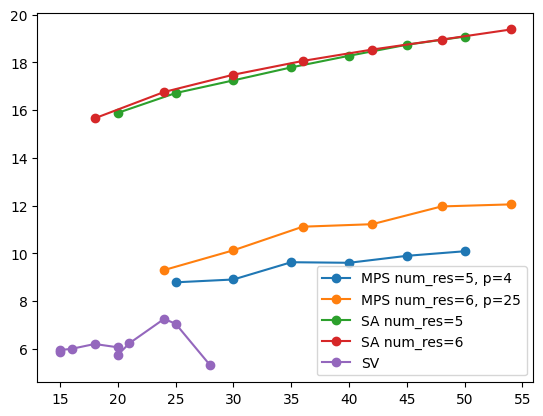

In [19]:
import matplotlib.pyplot as plt

plt.plot(x5_MPS, y5_MPS, 'o-', label=f'MPS num_res=5, p=4')
plt.plot(x6_MPS, y6_MPS, 'o-', label=f'MPS num_res=6, p=25')
plt.plot(x5_SA, y5_SA, 'o-', label=f'SA num_res=5')
plt.plot(x6_SA, y6_SA, 'o-', label=f'SA num_res=6')
plt.plot(x_sv_fit, y_sv_fit, 'o-', label=f'SV')
plt.legend()


In [20]:
# print gradients in a table format
import pandas as pd

gradients = {
    'num_res': [5, 6],
    'MPS_slope': [grad_res5_MPS, grad_res6_MPS],
    'SA_slope': [grad_res5_SA, grad_res6_SA],
    'MPS_slope_corrected': [grad_res5_MPS_corrected, grad_res6_MPS_corrected],
    'SA_slope_corrected': [grad_res5_SA_corrected, grad_res6_SA_corrected],
    'r2_value_MPS': [r2_res5_MPS, r2_res6_MPS],
    'r2_value_MPS_corrected': [r2_res5_MPS_corrected, r2_res6_MPS_corrected],
    'r2_value_SA': [r2_res5_SA, r2_res6_SA],
    'r2_value_corrected_SA': [r2_res5_SA_corrected, r2_res6_SA_corrected],
    'SV_slope': [slope_sv, slope_sv_corr],
    'r2_value_SV': [r2_sv, r2_sv_corr],
}

gradients_df = pd.DataFrame(gradients)

print(gradients_df.to_string())

NameError: name 'r2_sv' is not defined

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Merge SV data by unique x values
sv_df = pd.DataFrame({
    "x": x_sv_fit,
    "y": y_sv_corr_fit,
    "err": y_sv_err_fit
})

# Group by x, and average y and combine errors using RMS
merged_sv = sv_df.groupby("x").agg(
    y_mean=("y", "mean"),
    err_combined=("err", lambda e: np.sqrt(np.mean(e**2)))
).reset_index()

# Extract merged arrays
x_sv = merged_sv["x"].values
y_sv = merged_sv["y_mean"].values
y_sv_err = merged_sv["err_combined"].values

df_excl = pd.DataFrame({
    "x": x_sv_excl,
    "y": y_sv_excl,
    "err": y_sv_err_excl
})
merged_excl = df_excl.groupby("x").agg(
    y_mean=("y", "mean"),
    err_combined=("err", lambda e: np.sqrt(np.mean(e**2)))
).reset_index()
x_sv_excl = merged_excl["x"].values
y_sv_excl = merged_excl["y_mean"].values
y_sv_err_excl = merged_excl["err_combined"].values


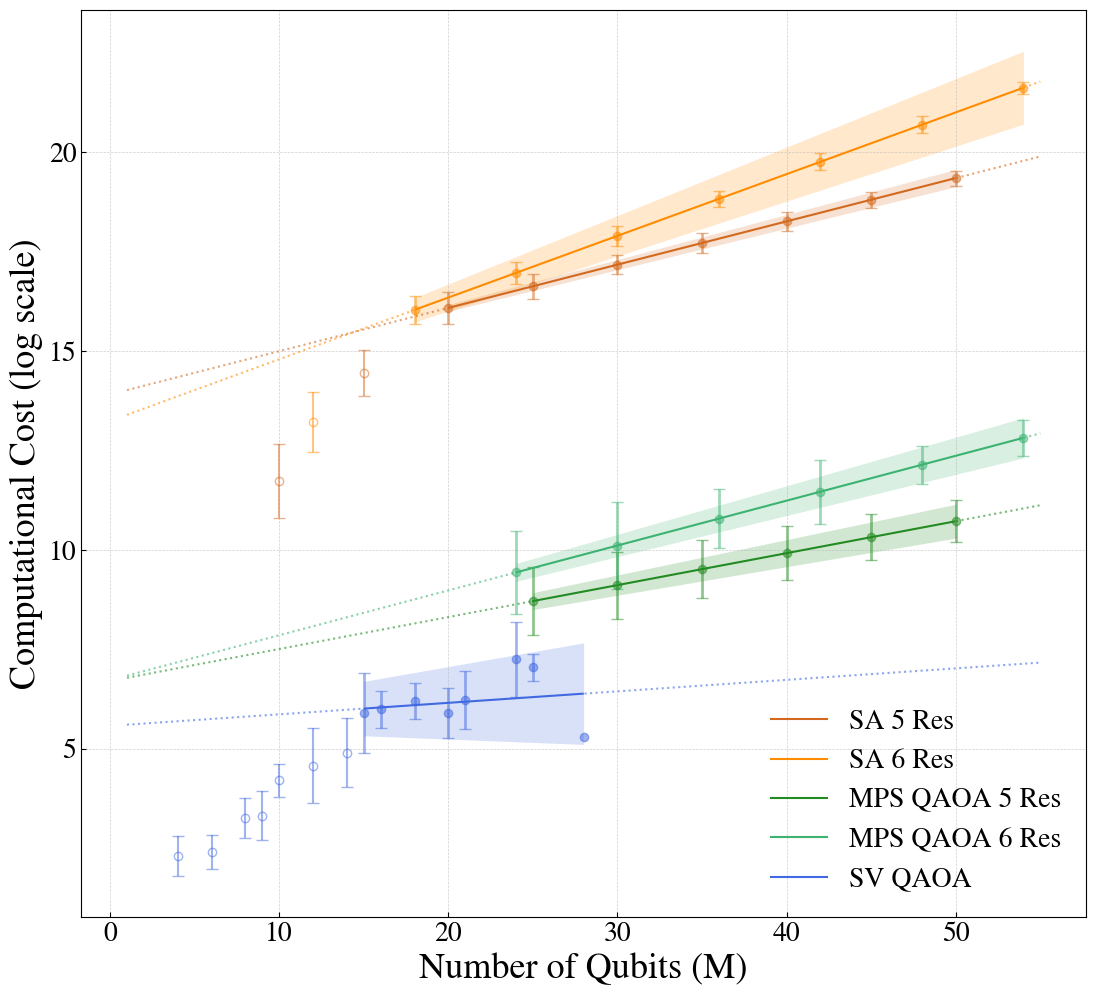

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Define consistent colors
color_5_mps = "forestgreen"
color_6_mps = "mediumseagreen"
color_5_sa = "#D2691E"
color_6_sa = "darkorange"
color_sv = "royalblue"

# Prepare plot
plt.figure(figsize=(11, 10))
plt.style.use('/Users/aag/Documents/proteinfolding/proteinfolding/molecular.mplstyle')

# Helper function to plot piecewise fit
def plot_piecewise_fit(x_data, slope, intercept, color, label):
    x_range = np.linspace(1, 55, 500)
    x_min = x_data.min()
    x_max = x_data.max()

    x_pre = x_range[x_range < x_min]
    x_mid = x_range[(x_range >= x_min) & (x_range <= x_max)]
    x_post = x_range[x_range > x_max]

    y_pre = slope * x_pre + intercept
    y_mid = slope * x_mid + intercept
    y_post = slope * x_post + intercept

    plt.plot(x_pre, y_pre, linestyle=":",  linewidth=1.5, color=color, alpha=0.6)
    plt.plot(x_mid, y_mid, linestyle="-",  linewidth=1.5, color=color, label=label)
    plt.plot(x_post, y_post, linestyle=":",  linewidth=1.5, color=color, alpha=0.6)

# === SA res=5 ===
y5_sa_fit = grad_res5_SA_corrected * x5_SA + intercept5_SA_corr
y5_sa_upper = (grad_res5_SA_corrected + std_err_5_SA_corr) * x5_SA + intercept5_SA_corr
y5_sa_lower = (grad_res5_SA_corrected - std_err_5_SA_corr) * x5_SA + intercept5_SA_corr
plt.errorbar(x5_SA, y5_sa_fit, yerr=y5_SA_err, fmt='o', color=color_5_sa, elinewidth=2, capsize=4, alpha=0.5)
plt.fill_between(x5_SA, y5_sa_lower, y5_sa_upper, color=color_5_sa, alpha=0.2, linewidth=0)
plot_piecewise_fit(x5_SA, grad_res5_SA_corrected, intercept5_SA_corr, color_5_sa, 'SA 5 Res')

plt.errorbar(
    excluded_x5_SA, excluded_y5_SA, yerr=excluded_err5_SA,
    fmt='o', linestyle='none', markerfacecolor='none', markeredgecolor=color_5_sa, ecolor=color_5_sa,
    capsize=4, alpha=0.5)

# === SA res=6 ===
y6_sa_fit = grad_res6_SA_corrected * x6_SA + intercept6_SA_corr
y6_sa_upper = (grad_res6_SA_corrected + std_err_6_SA_corr) * x6_SA + intercept6_SA_corr
y6_sa_lower = (grad_res6_SA_corrected - std_err_6_SA_corr) * x6_SA + intercept6_SA_corr
plt.errorbar(x6_SA, y6_sa_fit, yerr=y6_SA_err, fmt='o', color=color_6_sa ,elinewidth=2, capsize=4, alpha=0.5)
plt.fill_between(x6_SA, y6_sa_lower, y6_sa_upper, color=color_6_sa, alpha=0.2, linewidth=0)
plot_piecewise_fit(x6_SA, grad_res6_SA_corrected, intercept6_SA_corr, color_6_sa, 'SA 6 Res')

plt.errorbar(
    excluded_x6_SA, excluded_y6_SA, yerr=excluded_err6_SA,
    fmt='o', linestyle='none', markerfacecolor='none', markeredgecolor=color_6_sa, ecolor=color_6_sa,
    capsize=4, alpha=0.5)

# === MPS res=5 ===
y5_mps_fit = grad_res5_MPS_corrected * x5_MPS + intercept5_MPS_corr
y5_mps_upper = (grad_res5_MPS_corrected + std_err_5_MPS_corr) * x5_MPS + intercept5_MPS_corr
y5_mps_lower = (grad_res5_MPS_corrected - std_err_5_MPS_corr) * x5_MPS + intercept5_MPS_corr
plt.errorbar(x5_MPS, y5_mps_fit, yerr=y5_MPS_err, fmt='o', color=color_5_mps, elinewidth=2, capsize=4, alpha=0.5)
plt.fill_between(x5_MPS, y5_mps_lower, y5_mps_upper, color=color_5_mps, alpha=0.2, linewidth=0)
plot_piecewise_fit(x5_MPS, grad_res5_MPS_corrected, intercept5_MPS_corr, color_5_mps, 'MPS QAOA 5 Res')

# === MPS res=6 ===
y6_mps_fit = grad_res6_MPS_corrected * x6_MPS + intercept6_MPS_corr
y6_mps_upper = (grad_res6_MPS_corrected + std_err_6_MPS_corr) * x6_MPS + intercept6_MPS_corr
y6_mps_lower = (grad_res6_MPS_corrected - std_err_6_MPS_corr) * x6_MPS + intercept6_MPS_corr
plt.errorbar(x6_MPS, y6_mps_fit, yerr=y6_MPS_err, fmt='o', color=color_6_mps, elinewidth=2, capsize=4, alpha=0.5)
plt.fill_between(x6_MPS, y6_mps_lower, y6_mps_upper, color=color_6_mps, alpha=0.2, linewidth=0)
plot_piecewise_fit(x6_MPS, grad_res6_MPS_corrected, intercept6_MPS_corr, color_6_mps, 'MPS QAOA 6 Res')


# === SV ===
y_sv_fit = slope_sv_corr * x_sv + intercept_sv_corr
y_sv_upper = (slope_sv_corr + std_err_sv_corr) * x_sv + intercept_sv_corr
y_sv_lower = (slope_sv_corr - std_err_sv_corr) * x_sv + intercept_sv_corr
plt.fill_between(x_sv, y_sv_lower, y_sv_upper, color=color_sv, alpha=0.2, linewidth=0)
plt.errorbar(x_sv, y_sv, yerr=y_sv_err, fmt='o', color=color_sv, elinewidth=2, capsize=4, alpha=0.5)
plt.errorbar(
    x_sv_excl, y_sv_excl, yerr=y_sv_err_excl,
    fmt='o', linestyle='none', markerfacecolor='none', markeredgecolor=color_sv, ecolor=color_sv,
    capsize=4, alpha=0.5)

plot_piecewise_fit(x_sv, slope_sv_corr, intercept_sv_corr, color_sv, label='SV QAOA')

# Final touches
plt.xlabel("Number of Qubits (M)", fontsize=26)
plt.ylabel("Computational Cost (log scale)", fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, loc='lower right')
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.savefig("complexity_analysis_lin_reg.pdf", bbox_inches='tight', dpi=300)

plt.show()

# Save plot


In [756]:
(x_sv_fit_norm, y_sv_fit_norm, y_sv_corr_fit_norm, y_sv_err_fit_norm,
 x_sv_excl_norm, y_sv_excl_norm, y_sv_err_excl_norm,
 slope_sv_norm, slope_sv_corr_norm, r_sv_norm, r_sv_corr_norm, std_err_sv_corr_norm, intercept_sv_corr_norm
) = plot_qpu_calls_vs_complexity_path_sv(path_SV, p=4, fit_mask_min=15, normalise=True)

x5_MPS_norm, y5_MPS_norm, y5_MPS_corrected_norm, y5_MPS_err_norm, grad_res5_MPS_norm, grad_res5_MPS_corrected_norm, r2_res5_MPS_norm, r2_res5_MPS_corrected_norm, std_err_5_MPS_corr_norm, intercept5_MPS_corr_norm = plot_qpu_calls_vs_complexity(df_res5_MPS, num_res=5, p=4, fit_mask_min=1, normalise=True)
x6_MPS_norm, y6_MPS_norm, y6_MPS_corrected_norm, y6_MPS_err_norm, grad_res6_MPS_norm, grad_res6_MPS_corrected_norm, r2_res6_MPS_norm, r2_res6_MPS_corrected_norm, std_err_6_MPS_corr_norm, intercept6_MPS_corr_norm = plot_qpu_calls_vs_complexity(df_res6_MPS, num_res=6, p=25, fit_mask_min=1, normalise=True)

x5_SA_norm, y5_SA_norm, y5_SA_corrected_norm, y5_SA_err_norm, excluded_x5_SA, excluded_y5_SA, excluded_err5_SA, grad_res5_SA_norm, grad_res5_SA_corrected_norm, r2_res5_SA_norm, r2_res5_SA_corrected_norm, std_err_5_SA_corr_norm, intercept5_SA_corr_norm = analyze_cpu_calls_vs_complexity(df_res5_SA, num_res=5,fit_mask_min=18, normalise=True)
x6_SA_norm, y6_SA_norm, y6_SA_corrected_norm, y6_SA_err_norm, excluded_x6_SA, excluded_y6_SA, excluded_err6_SA, grad_res6_SA_norm, grad_res6_SA_corrected_norm, r2_res6_SA_norm, r2_res6_SA_corrected_norm, std_err_6_SA_corr_norm, intercept6_SA_corr_norm = analyze_cpu_calls_vs_complexity(df_ref6_SA, num_res=6, fit_mask_min=18, normalise=True)


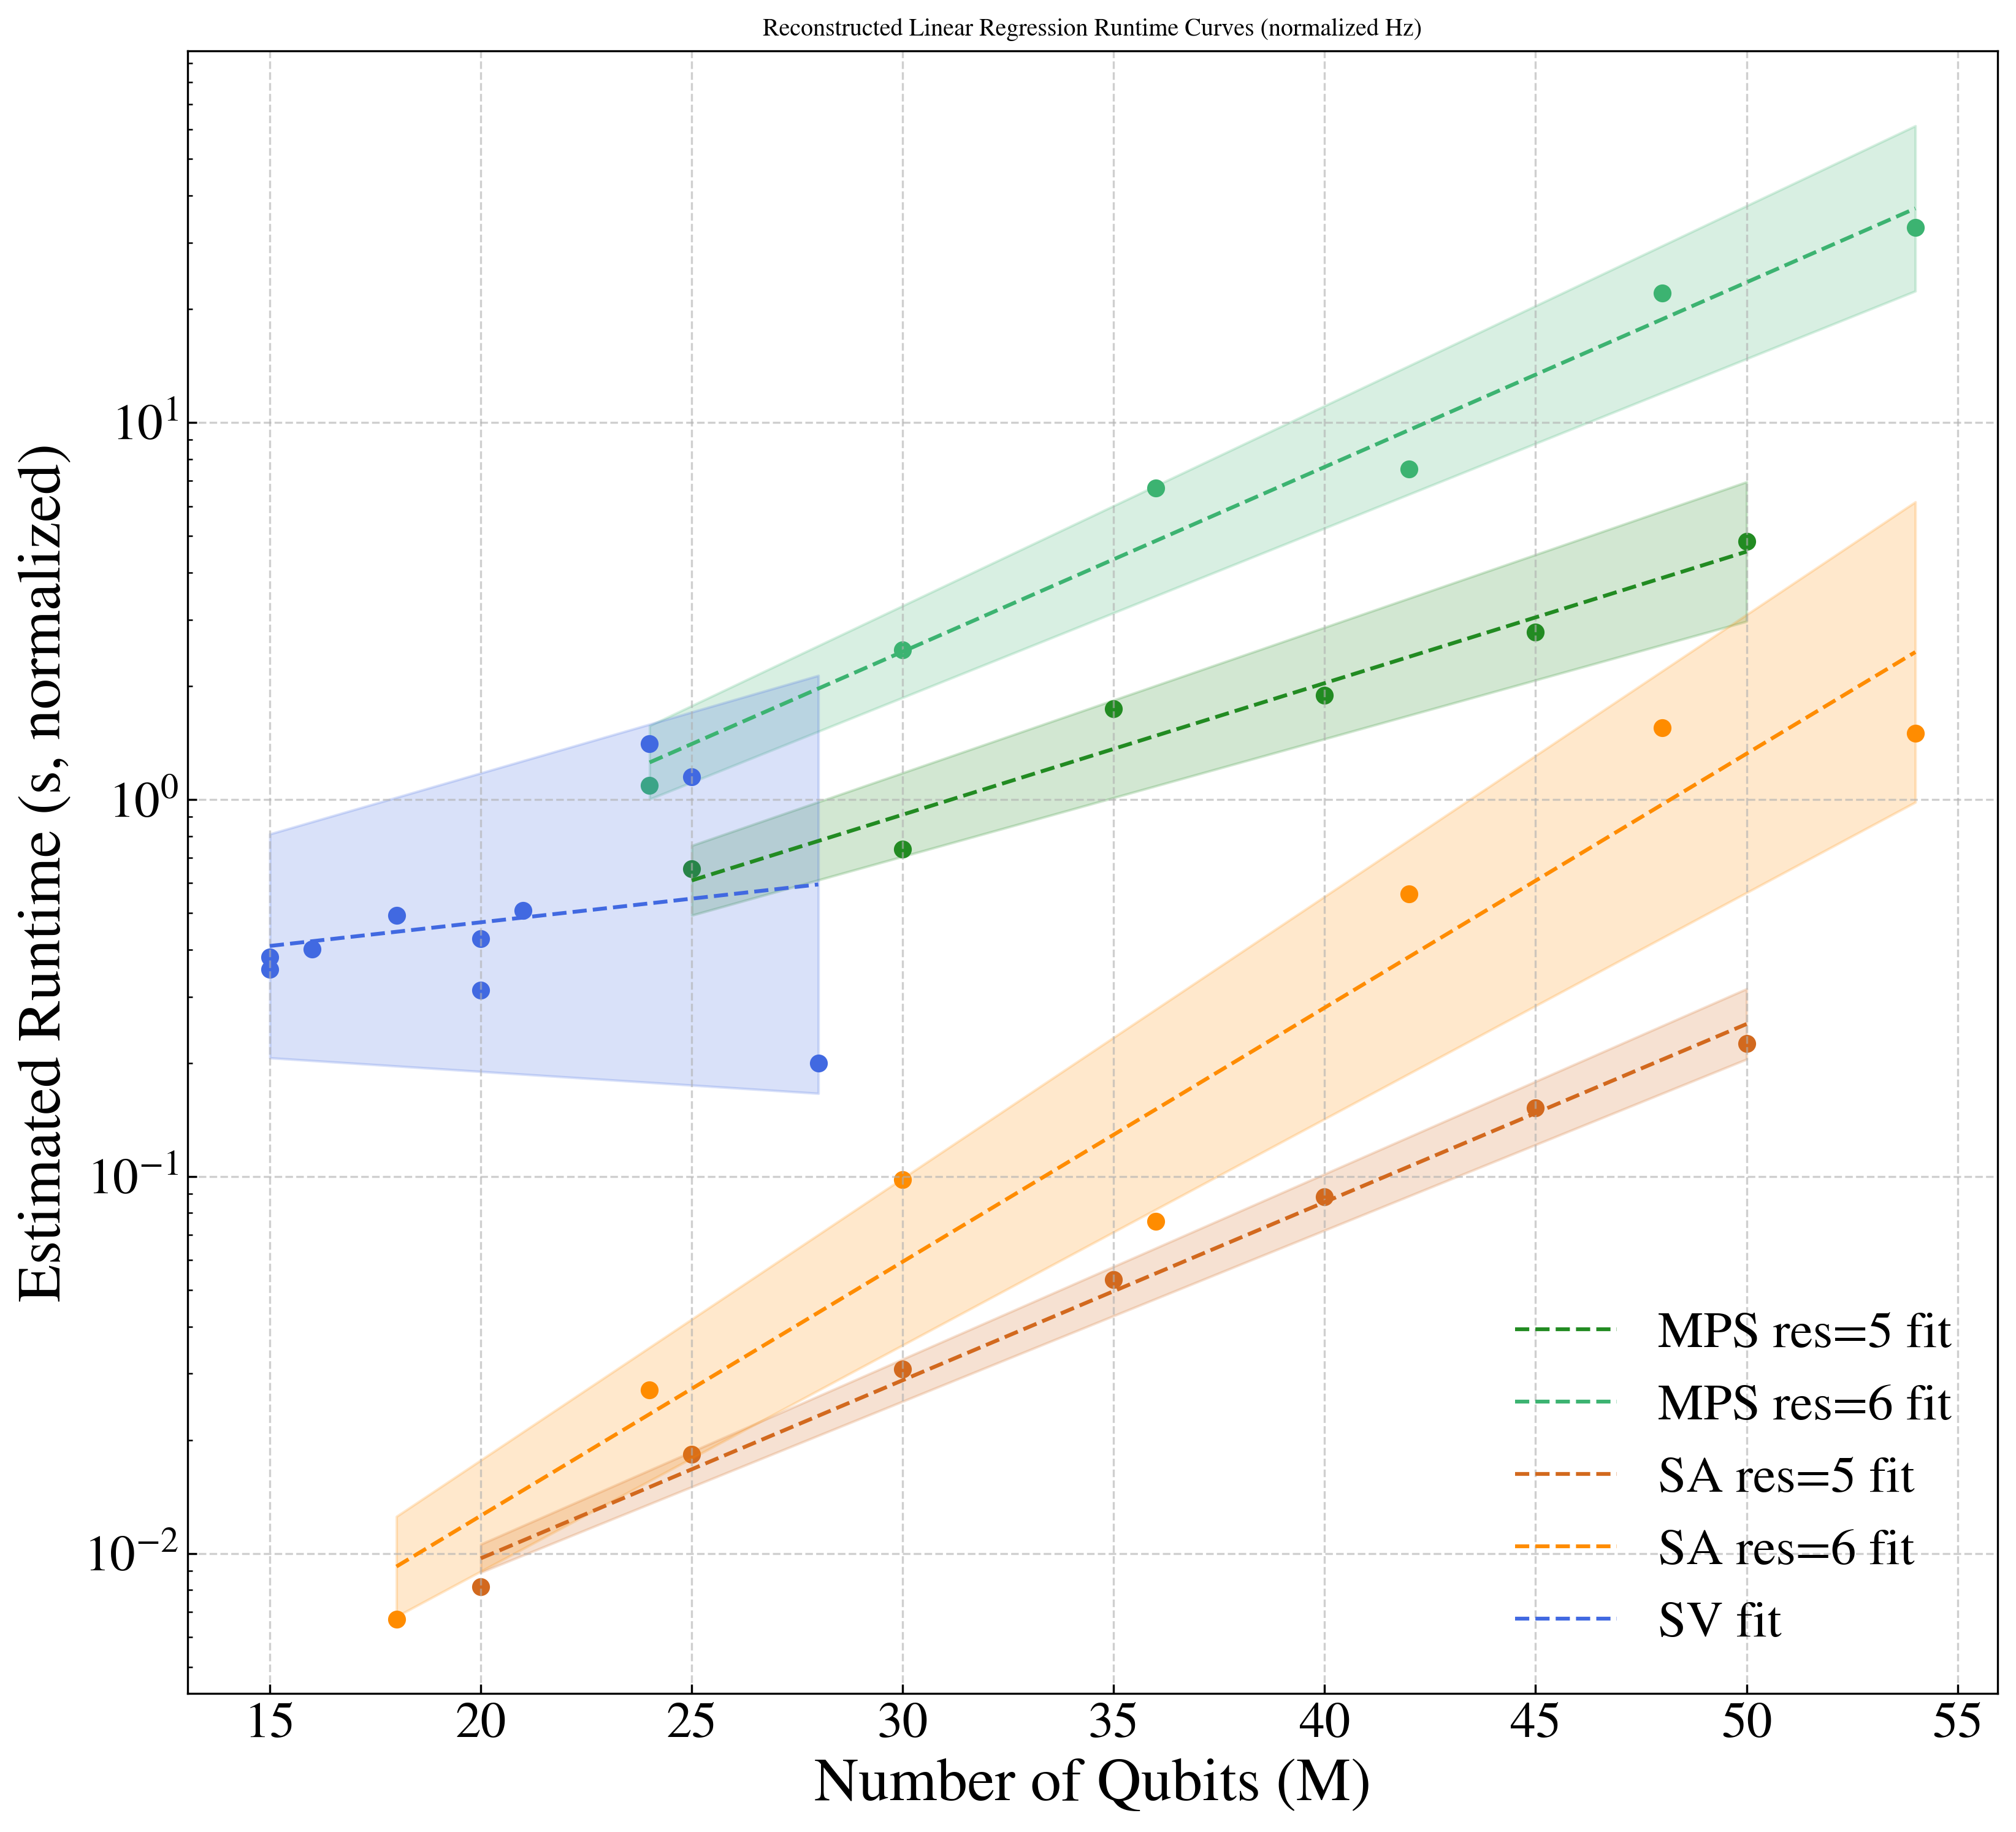

In [757]:
plt.figure(figsize=(11, 10))

# === MPS res=5 ===
slope = grad_res5_MPS_corrected_norm
intercept = (y5_MPS_corrected_norm - slope * x5_MPS_norm).mean()
std_err = std_err_5_MPS_corr_norm

runtime_fit = np.exp(intercept + slope * x5_MPS_norm)
runtime_upper = np.exp(intercept + (slope + std_err) * x5_MPS_norm)
runtime_lower = np.exp(intercept + (slope - std_err) * x5_MPS_norm)

plt.plot(x5_MPS_norm, runtime_fit, '--', label='MPS res=5 fit', color=color_5_mps)
plt.fill_between(x5_MPS_norm, runtime_lower, runtime_upper, color=color_5_mps, alpha=0.2)
plt.scatter(x5_MPS_norm, np.exp(y5_MPS_corrected_norm), color=color_5_mps, marker='o')

# === MPS res=6 ===
slope = grad_res6_MPS_corrected_norm
intercept = (y6_MPS_corrected_norm - slope * x6_MPS_norm).mean()
std_err = std_err_6_MPS_corr_norm

runtime_fit = np.exp(intercept + slope * x6_MPS_norm)
runtime_upper = np.exp(intercept + (slope + std_err) * x6_MPS_norm)
runtime_lower = np.exp(intercept + (slope - std_err) * x6_MPS_norm)

plt.plot(x6_MPS_norm, runtime_fit, '--', label='MPS res=6 fit', color=color_6_mps)
plt.fill_between(x6_MPS_norm, runtime_lower, runtime_upper, color=color_6_mps, alpha=0.2)
plt.scatter(x6_MPS_norm, np.exp(y6_MPS_corrected_norm), color=color_6_mps, marker='o')

# === SA res=5 ===
slope = grad_res5_SA_corrected_norm
intercept = (y5_SA_corrected_norm - slope * x5_SA_norm).mean()
std_err = std_err_5_SA_corr_norm

runtime_fit = np.exp(intercept + slope * x5_SA_norm)
runtime_upper = np.exp(intercept + (slope + std_err) * x5_SA_norm)
runtime_lower = np.exp(intercept + (slope - std_err) * x5_SA_norm)

plt.plot(x5_SA_norm, runtime_fit, '--', label='SA res=5 fit', color=color_5_sa)
plt.fill_between(x5_SA_norm, runtime_lower, runtime_upper, color=color_5_sa, alpha=0.2)
plt.scatter(x5_SA_norm, np.exp(y5_SA_corrected_norm), color=color_5_sa, marker='o')

# === SA res=6 ===
slope = grad_res6_SA_corrected_norm
intercept = (y6_SA_corrected_norm - slope * x6_SA_norm).mean()
std_err = std_err_6_SA_corr_norm

runtime_fit = np.exp(intercept + slope * x6_SA_norm)
runtime_upper = np.exp(intercept + (slope + std_err) * x6_SA_norm)
runtime_lower = np.exp(intercept + (slope - std_err) * x6_SA_norm)

plt.plot(x6_SA_norm, runtime_fit, '--', label='SA res=6 fit', color=color_6_sa)
plt.fill_between(x6_SA_norm, runtime_lower, runtime_upper, color=color_6_sa, alpha=0.2)
plt.scatter(x6_SA_norm, np.exp(y6_SA_corrected_norm), color=color_6_sa, marker='o')

# === SV ===
slope = slope_sv_corr_norm
intercept = (y_sv_corr_fit_norm - slope * x_sv_fit_norm).mean()
std_err = std_err_sv_corr_norm

runtime_fit = np.exp(intercept + slope * x_sv_fit_norm)
runtime_upper = np.exp(intercept + (slope + std_err) * x_sv_fit_norm)
runtime_lower = np.exp(intercept + (slope - std_err) * x_sv_fit_norm)

plt.plot(x_sv_fit_norm, runtime_fit, '--', label='SV fit', color=color_sv)
plt.fill_between(x_sv_fit_norm, runtime_lower, runtime_upper, color=color_sv, alpha=0.2)
plt.scatter(x_sv_fit_norm, np.exp(y_sv_corr_fit_norm), color=color_sv, marker='o')

# Plot formatting
plt.yscale("log")
plt.xlabel("Number of Qubits (M)", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Estimated Runtime (s, normalized)", fontsize=24)
plt.title("Reconstructed Linear Regression Runtime Curves (normalized Hz)")
plt.legend(fontsize=20, loc='lower right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [760]:
# Extend the log-linear model back into a linear scale plot of runtime with crossover
def plot_corrected_runtime_with_crossover_fixed(x_mps, y_mps, y_mps_err, slope_mps, intercept_mps, std_err_mps,
                                                x_sa, y_sa, y_sa_err, slope_sa, intercept_sa, std_err_sa,
                                                x_sv, y_sv, y_sv_err, slope_sv, intercept_sv, std_err_sv,
                                                x_sv_excl, y_sv_excl, y_sv_err_excl, num_res,
                                                label_mps="MPS", label_sa="SA", label_sv="SV",
                                                resolution=6):
    # Extract exponential parameters
    A_mps = np.exp(intercept_mps)
    A_sa = np.exp(intercept_sa)
    A_sv = np.exp(intercept_sv)
    B_mps = slope_mps
    B_sa = slope_sa
    B_sv = slope_sv

    # Crossover point between MPS and SA
    x_cross = None
    y_cross = None
    if np.abs(B_mps - B_sa) > 1e-6:
        x_cross_est = (np.log(A_sa) - np.log(A_mps)) / (B_mps - B_sa)
        if x_cross_est >= min(x_mps.min(), x_sa.min()):
            x_cross = x_cross_est
            y_cross = A_mps * np.exp(B_mps * x_cross)

    # Define x range
    x_min = min(x_mps.min(), x_sa.min(), x_sv.min())
    x_max_data = max(x_mps.max(), x_sa.max(), x_sv.max())
    x_range_solid = np.linspace(x_min, x_max_data, 300)
    x_range_extrap = np.linspace(x_max_data, 180, 300)

    # Evaluate fits
    y_mps_solid = A_mps * np.exp(B_mps * x_range_solid)
    y_sa_solid = A_sa * np.exp(B_sa * x_range_solid)
    y_sv_solid = A_sv * np.exp(B_sv * x_range_solid)

    y_mps_extrap = A_mps * np.exp(B_mps * x_range_extrap)
    y_sa_extrap = A_sa * np.exp(B_sa * x_range_extrap)
    y_sv_extrap = A_sv * np.exp(B_sv * x_range_extrap)


    plt.figure(figsize=(11, 10))

    # Plot points
    # plt.plot(x_mps, np.exp(y_mps), 'o', color="mediumseagreen")
    # plt.plot(x_sa, np.exp(y_sa), 'o', color="darkorange")
    # plt.plot(x_sv, np.exp(y_sv), 'o', color="royalblue")

    # Solid lines (fit range)
    plt.plot(x_range_solid, y_sa_solid, label=f"{label_sa}", linestyle="-", color="darkorange", linewidth=1.5)
    plt.plot(x_range_solid, y_mps_solid, label=f"{label_mps} QAOA", linestyle="-", color="mediumseagreen", linewidth=1.5)
    plt.plot(x_range_solid, y_sv_solid, label=f"{label_sv} QAOA", linestyle="-", color="royalblue", linewidth=1.5)

    # Dotted lines (extrapolation)
    plt.plot(x_range_extrap, y_mps_extrap, linestyle=":", color="mediumseagreen", alpha=0.6, linewidth=1.5)
    plt.plot(x_range_extrap, y_sa_extrap, linestyle=":", color="darkorange", alpha=0.6, linewidth=1.5)
    plt.plot(x_range_extrap, y_sv_extrap, linestyle=":", color="royalblue", alpha=0.6, linewidth=1.5)

    # Plot error bars
    x_mps_full = np.concatenate([x_range_solid, x_range_extrap])
    y_mps_upper = np.exp((slope_mps + std_err_mps) * x_mps_full + intercept_mps)
    y_mps_lower = np.exp((slope_mps - std_err_mps) * x_mps_full + intercept_mps)
    plt.fill_between(x_mps_full, y_mps_lower, y_mps_upper, color="mediumseagreen", alpha=0.2, linewidth=0)

    y_mps_linear = np.exp(y_mps)
    y_mps_err_upper = np.exp(y_mps + y_mps_err) - y_mps_linear
    y_mps_err_lower = y_mps_linear - np.exp(y_mps - y_mps_err)

    plt.errorbar(x_mps, y_mps_linear, 
                yerr=[y_mps_err_lower, y_mps_err_upper], 
                fmt='o', color="mediumseagreen",  elinewidth=2, capsize=4, alpha=0.5)

    x_sa_full = np.concatenate([x_range_solid, x_range_extrap])
    y_sa_upper = np.exp((slope_sa + std_err_sa) * x_sa_full + intercept_sa)
    y_sa_lower = np.exp((slope_sa - std_err_sa) * x_sa_full + intercept_sa)
    plt.fill_between(x_sa_full, y_sa_lower, y_sa_upper, color="darkorange", alpha=0.2, linewidth=0)

    y_sa_linear = np.exp(y_sa)
    y_sa_err_upper = np.exp(y_sa + y_sa_err) - y_sa_linear
    y_sa_err_lower = y_sa_linear - np.exp(y_sa - y_sa_err)

    plt.errorbar(x_sa, y_sa_linear, 
                yerr=[y_sa_err_lower, y_sa_err_upper], 
                fmt='o', color='darkorange', elinewidth=2, capsize=4, alpha=0.5)


    y_sv_upper = np.exp((slope_sv + std_err_sv) * x_sv + intercept_sv)
    y_sv_lower = np.exp((slope_sv - std_err_sv) * x_sv + intercept_sv)
    plt.fill_between(x_sv, y_sv_lower, y_sv_upper, color="royalblue", alpha=0.2, linewidth=0)

    y_sv_linear = np.exp(y_sv)
    y_sv_err_upper = np.exp(y_sv + y_sv_err) - y_sv_linear
    y_sv_err_lower = y_sv_linear - np.exp(y_sv - y_sv_err)

    plt.errorbar(x_sv, y_sv_linear, 
                yerr=[y_sv_err_lower, y_sv_err_upper], 
                fmt='o', color='royalblue', elinewidth=2, capsize=4, alpha=0.5)


    # Excluded points as empty circles
    y_sv_excl_linear = np.exp(y_sv_excl)
    y_sv_err_upper_excl = np.exp(y_sv_excl + y_sv_err_excl) - y_sv_excl_linear
    y_sv_err_lower_excl = y_sv_excl_linear - np.exp(y_sv_excl - y_sv_err_excl)

    plt.errorbar(
        x_sv_excl, y_sv_excl_linear, 
        yerr=[y_sv_err_lower_excl, y_sv_err_upper_excl],
        fmt='o', linestyle='none',
        markerfacecolor='none',color='royalblue', ecolor='royalblue',
        capsize=4, alpha=0.5)
    

    # Crossover
    # if x_cross is not None:
    #     plt.scatter([x_cross], [y_cross], color="black", label=f"Crossover MPS–SA at x = {x_cross:.1f}")
    
    x_cross_bounds = None
    y_cross_bounds = None
    numerator = intercept_sa - intercept_mps
    denominator = (slope_mps + std_err_mps) - (slope_sa - std_err_sa)

    if np.abs(denominator) > 1e-6:
        x_cross_bounds_est = numerator / denominator
        if x_cross_bounds_est >= min(x_mps.min(), x_sa.min()):
            x_cross_bounds = x_cross_bounds_est
            y_cross_bounds = np.exp((slope_mps + std_err_mps) * x_cross_bounds + intercept_mps)
    
    if x_cross_bounds is not None:
        print(f"Conservative crossover (MPS upper vs SA lower) at x = {x_cross_bounds:.2f}, y = {y_cross_bounds:.2e}")
        print(f"Crossover poitn MPS and SA fit at x = {x_cross:.2f}, y = {y_cross:.2e}")
    plt.style.use('/Users/aag/Documents/proteinfolding/proteinfolding/molecular.mplstyle')

    # Labels and formatting
    plt.yscale("log")
    plt.xlabel("Number of Qubits (M)", fontsize=26)
    plt.ylabel("Estimated Runtime (log scale)", fontsize=26)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20, loc='lower right')
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    ax = plt.gca()

    # add the panel label in axes coords: (0,0)=bottom-left, (1,1)=top-right
    ax.text(
        0.02, 0.95,    # x, y in axes‐coords
        "(b)",         # the label you want
        transform=ax.transAxes,
        fontsize=24,
        va="top",      # vertical alignment
        ha="left"      # horizontal alignment
    )
    
    plt.tight_layout()
    plt.xlim(10, 165)
    plt.savefig(f"estimated_runtime_{num_res}_lin_reg.pdf", bbox_inches='tight', dpi=300)
    plt.show()



Conservative crossover (MPS upper vs SA lower) at x = 311.74, y = 2.88e+15
Crossover poitn MPS and SA fit at x = 117.97, y = 5.03e+04


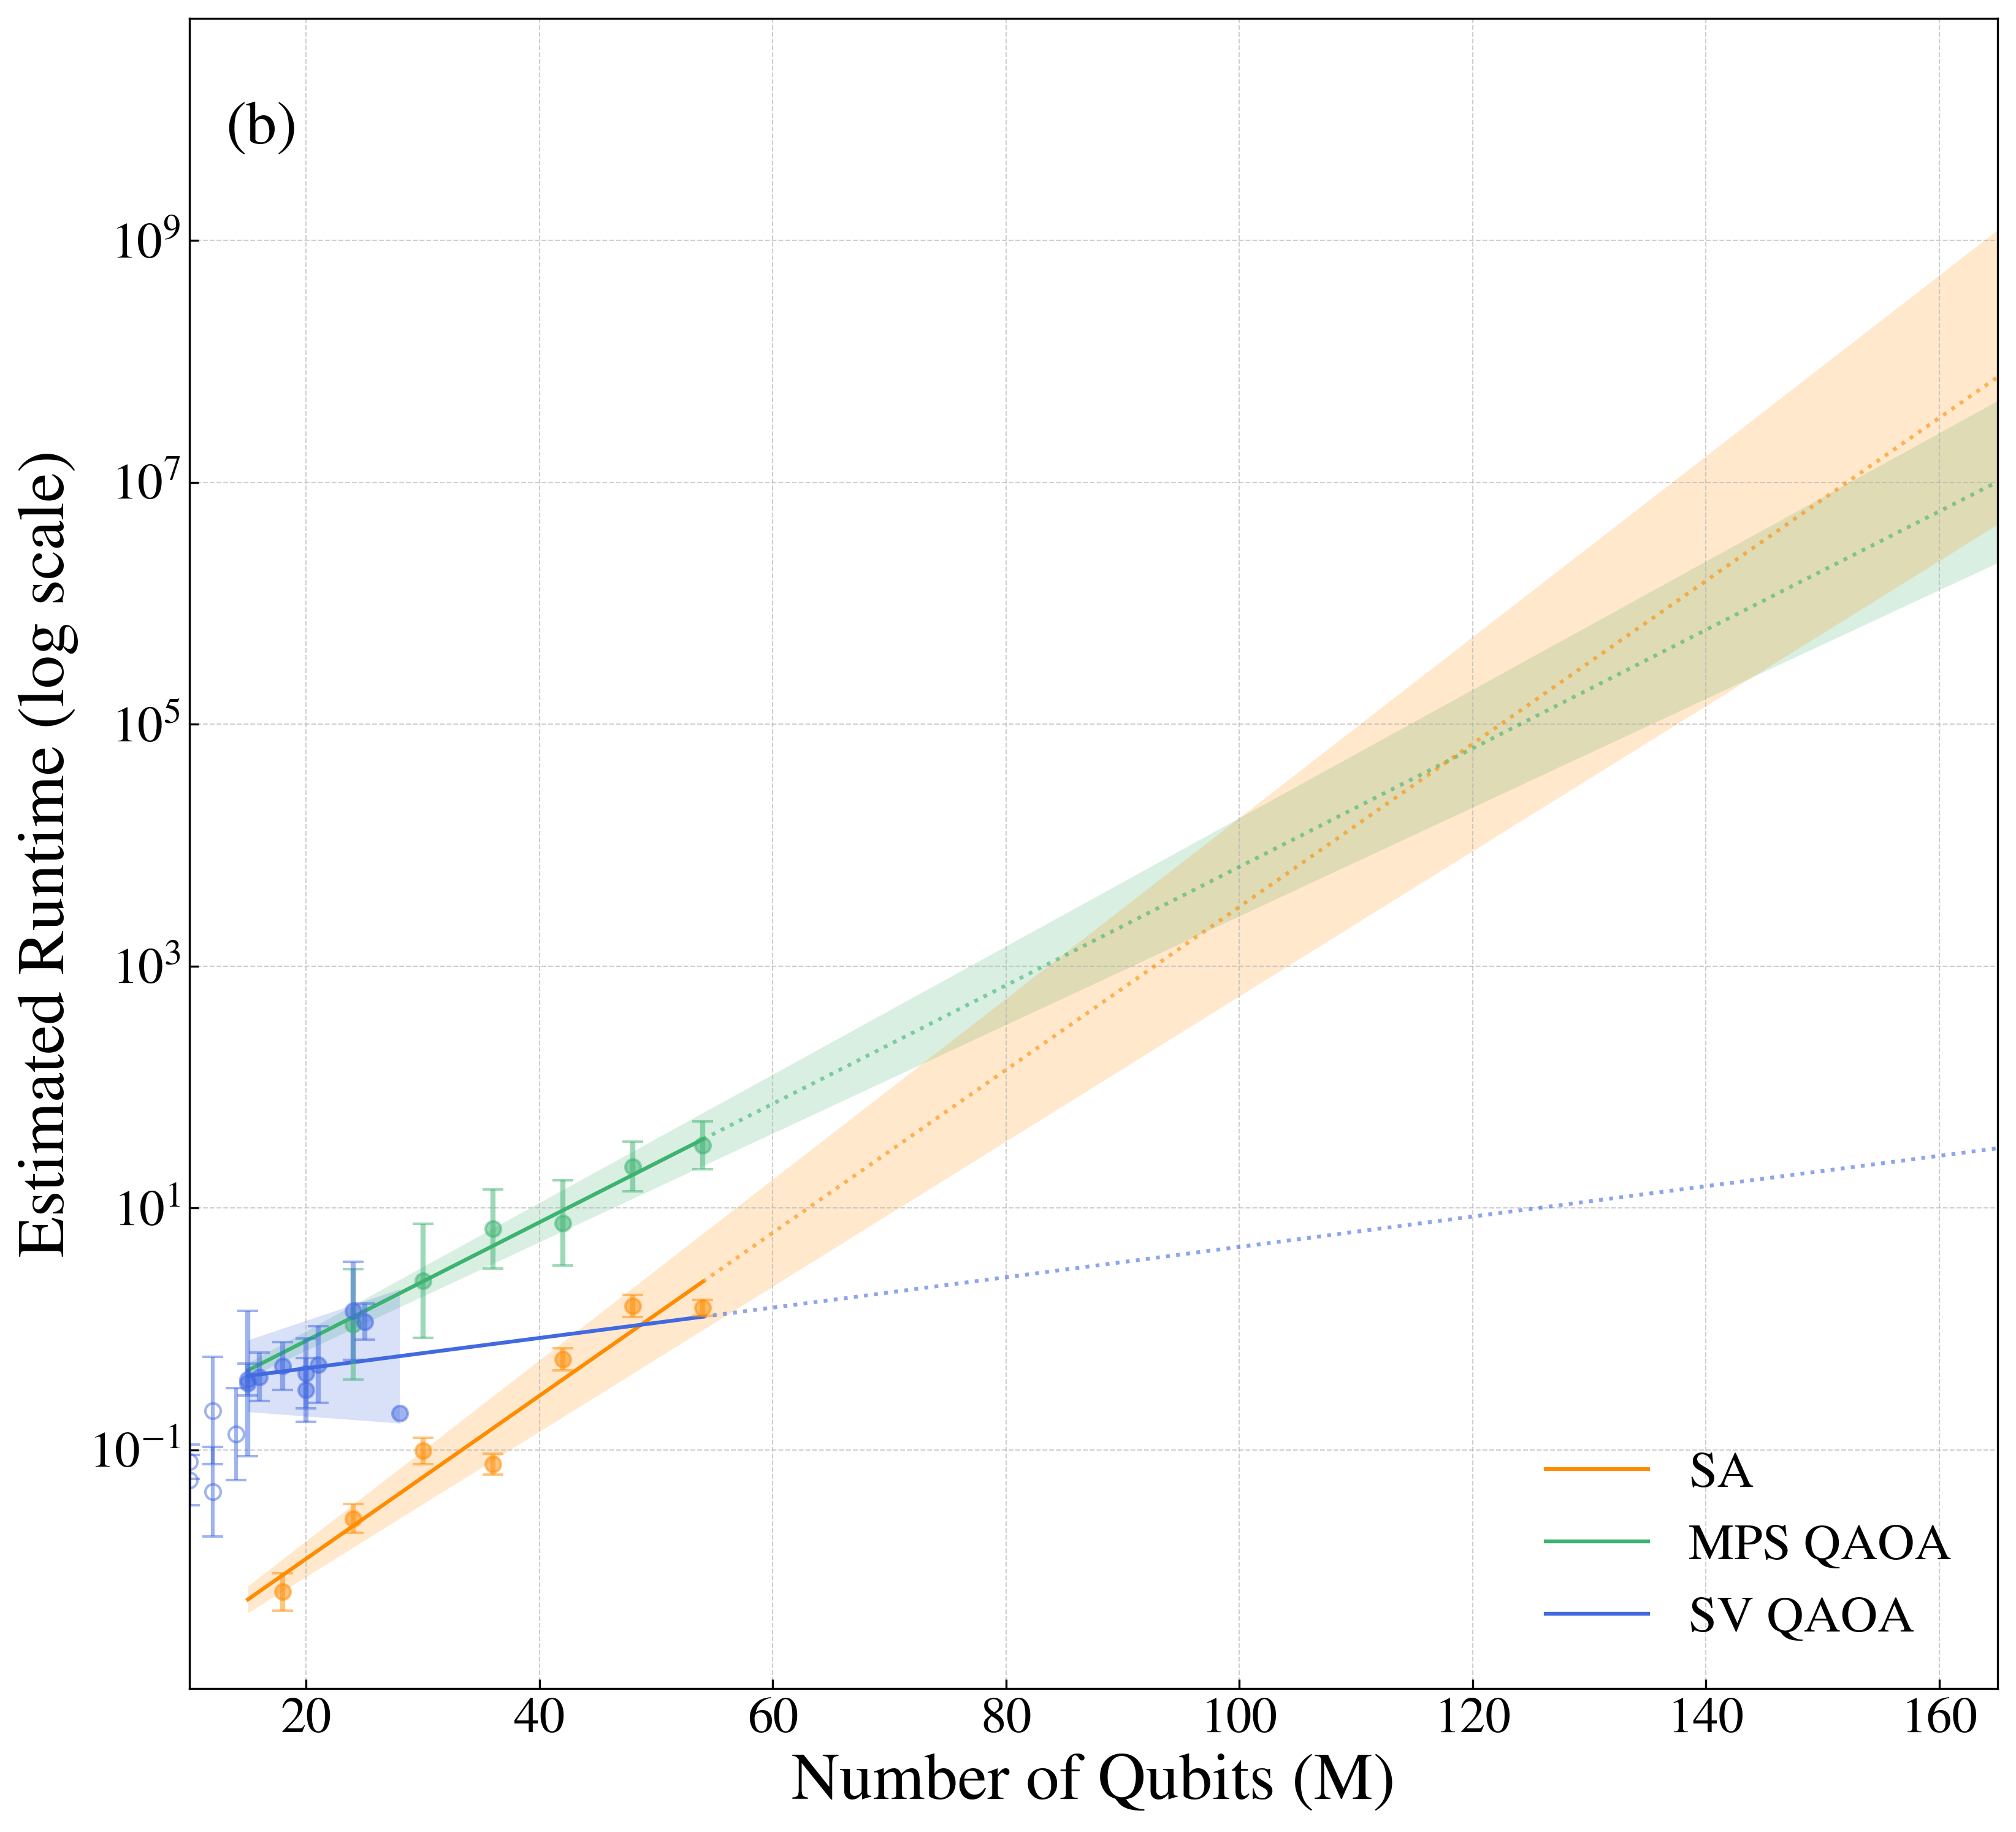

In [761]:
plot_corrected_runtime_with_crossover_fixed(
    x6_MPS_norm, y6_MPS_corrected_norm, y6_MPS_err_norm, grad_res6_MPS_corrected_norm, intercept6_MPS_corr_norm, std_err_6_MPS_corr_norm,
    x6_SA_norm, y6_SA_corrected_norm, y6_SA_err_norm, grad_res6_SA_corrected_norm, intercept6_SA_corr_norm, std_err_6_SA_corr_norm,
    x_sv_fit_norm, y_sv_corr_fit_norm, y_sv_err_fit_norm, slope_sv_corr_norm, intercept_sv_corr_norm, std_err_sv_corr_norm,
    x_sv_excl_norm, y_sv_excl_norm, y_sv_err_excl_norm, 6,
    resolution=6
)

Conservative crossover (MPS upper vs SA lower) at x = 275.62, y = 3.54e+09
Crossover poitn MPS and SA fit at x = 151.43, y = 1.57e+04


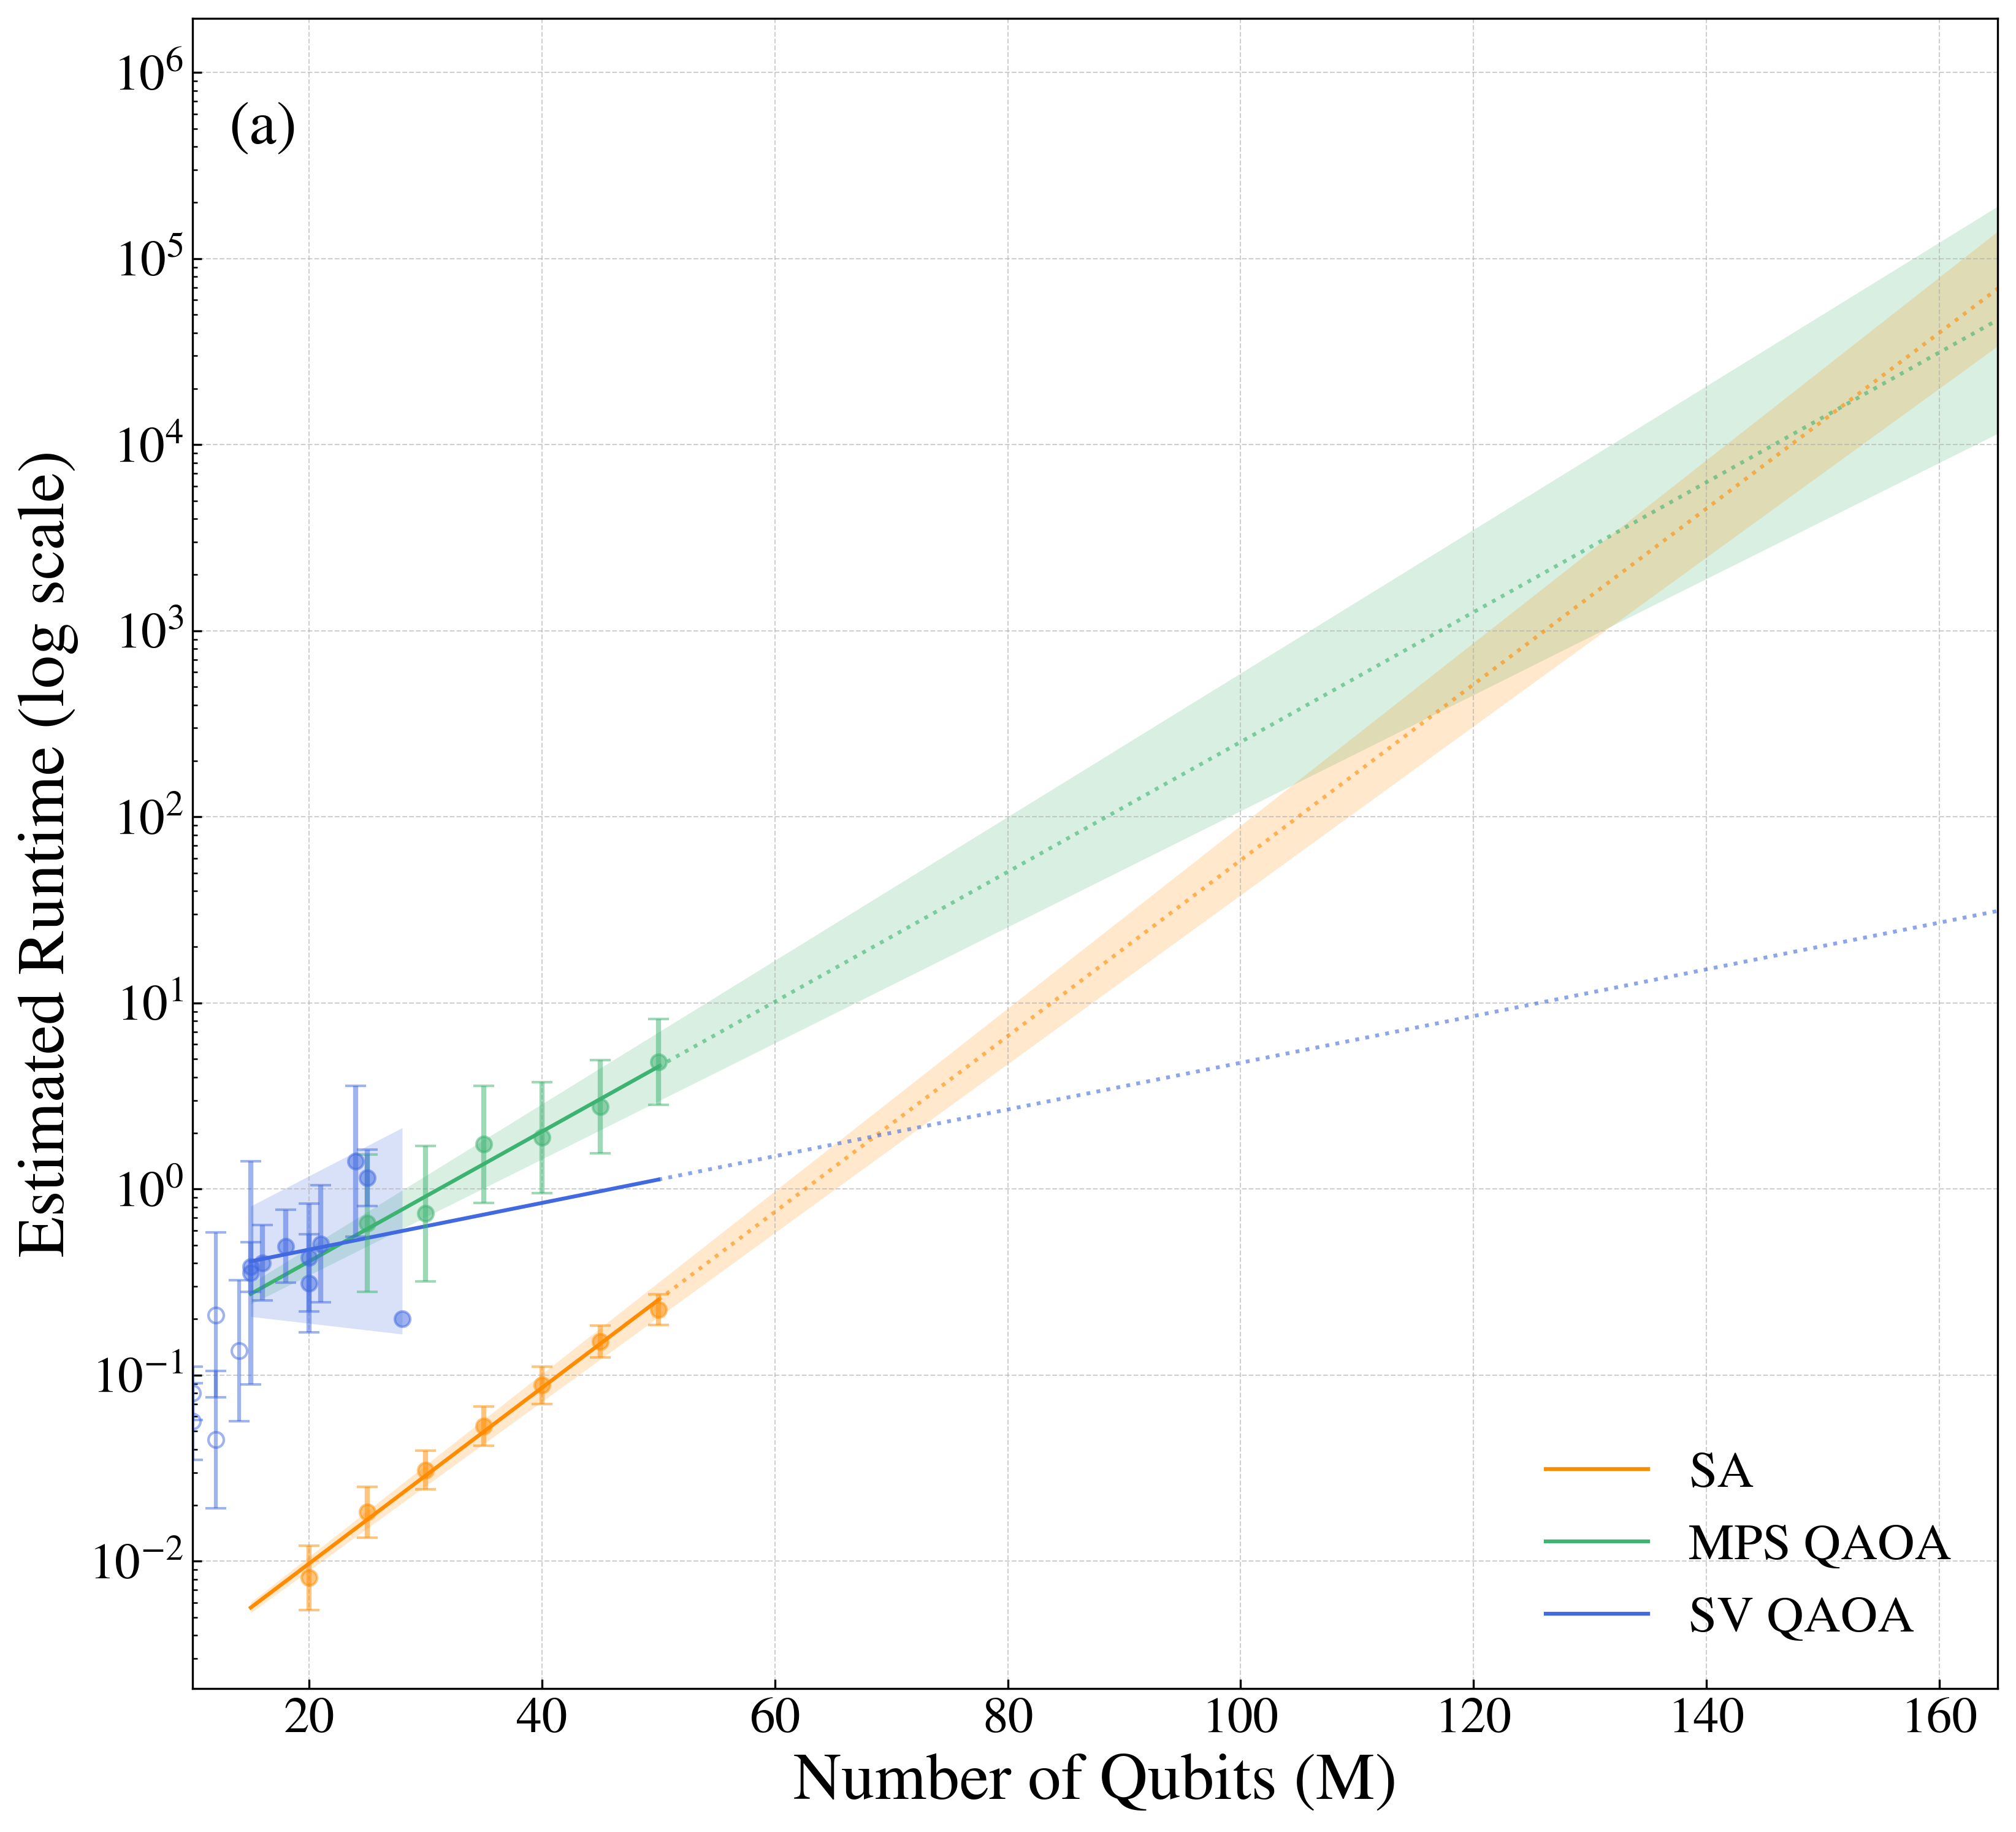

In [759]:
plot_corrected_runtime_with_crossover_fixed(
    x5_MPS_norm, y5_MPS_corrected_norm, y5_MPS_err_norm, grad_res5_MPS_corrected_norm, intercept5_MPS_corr_norm, std_err_5_MPS_corr_norm,
    x5_SA_norm, y5_SA_corrected_norm, y5_SA_err_norm, grad_res5_SA_corrected_norm, intercept5_SA_corr_norm, std_err_5_SA_corr_norm,
    x_sv_fit_norm, y_sv_corr_fit_norm, y_sv_err_fit_norm, slope_sv_corr_norm, intercept_sv_corr_norm, std_err_sv_corr_norm,
    x_sv_excl_norm, y_sv_excl_norm, y_sv_err_excl_norm, 5,
    resolution=6
)